## A New Framework Combining Diffusion Models and the Convolution Classifier for Generating Images from EEG Signals

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [11]:
import numpy as np
import time
from sklearn.model_selection import train_test_split

In [28]:
BATCH_SIZE = 64
CLASSES = 40
EPOCHS = 100

## Data

Data Availability Statement: The data used in this article can be accessed at https://tinyurl.com/eeg-visual-classification (accessed on 8 September 2023). And the code is at https://github.com/perceivelab/eeg_visual_classification (accessed on 8 September 2023).).

In [29]:
dataset = torch.load('datasets/eeg_conDiff/eeg_14_70_std.pth')
dataset_data = dataset['dataset']
dataset_labels = dataset['labels']
dataset_images = dataset['images']

In [30]:
dataset_data[0], dataset_labels[0], dataset_images[0]

({'eeg': tensor([[-1.6570e-02,  2.7305e-02,  8.0402e-02,  ..., -7.7733e-05,
           -1.9835e-02, -1.5594e-02],
          [-1.0071e-02,  1.1867e-01,  2.4788e-01,  ...,  1.8917e-02,
           -8.7614e-03, -1.9201e-02],
          [ 2.5684e-02, -1.7518e-01, -3.8919e-01,  ..., -1.4881e-01,
           -5.8758e-02,  1.8632e-02],
          ...,
          [ 1.6717e-02,  4.4144e-02,  7.0098e-02,  ...,  1.6365e-01,
            8.8041e-02, -7.7776e-03],
          [-1.6673e-03, -4.8546e-03, -7.2816e-03,  ...,  5.2610e-03,
            1.6651e-03, -2.9540e-03],
          [ 6.4596e-03,  3.2524e-02,  6.4534e-02,  ...,  8.3441e-02,
            3.8469e-02, -1.5483e-02]]),
  'image': 0,
  'label': 10,
  'subject': 4},
 'n02389026',
 'n02951358_31190')

In [31]:
N = len(dataset_data)
C = 128
S = 440

data = torch.zeros(N, C, S)
labels = torch.zeros(N, dtype=torch.long)
images = torch.zeros(N, dtype=torch.long)

for i in range(N):
    data[i] = dataset_data[i]['eeg'][:, 20:S+20]
    labels[i] = dataset_data[i]['label']
    images[i] = dataset_data[i]['image']

In [32]:
data.shape, labels.shape, images.shape

(torch.Size([11965, 128, 440]), torch.Size([11965]), torch.Size([11965]))

In [33]:
data[0], labels[0], images[0]

(tensor([[-0.3839, -0.3928, -0.3551,  ..., -0.1582, -0.2382, -0.3021],
         [-0.5158, -0.5182, -0.4726,  ..., -0.0762, -0.1607, -0.2387],
         [ 0.7205,  0.6727,  0.5448,  ...,  0.6293,  0.7482,  0.8191],
         ...,
         [-0.1903, -0.1702, -0.1408,  ...,  0.2865,  0.2112,  0.1306],
         [-0.0229, -0.0211, -0.0183,  ...,  0.0112,  0.0077,  0.0043],
         [-0.3500, -0.3306, -0.2864,  ...,  0.1132,  0.0422, -0.0200]]),
 tensor(10),
 tensor(0))

### Add the channels dimension

In [34]:
data = torch.unsqueeze(data, 1)
data.shape

torch.Size([11965, 1, 128, 440])

### Split into train, validation, test

In [35]:
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [36]:
x_train.shape, x_val.shape, x_test.shape

(torch.Size([8375, 1, 128, 440]),
 torch.Size([1795, 1, 128, 440]),
 torch.Size([1795, 1, 128, 440]))

### Define datasets and loaders

In [37]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

## Model

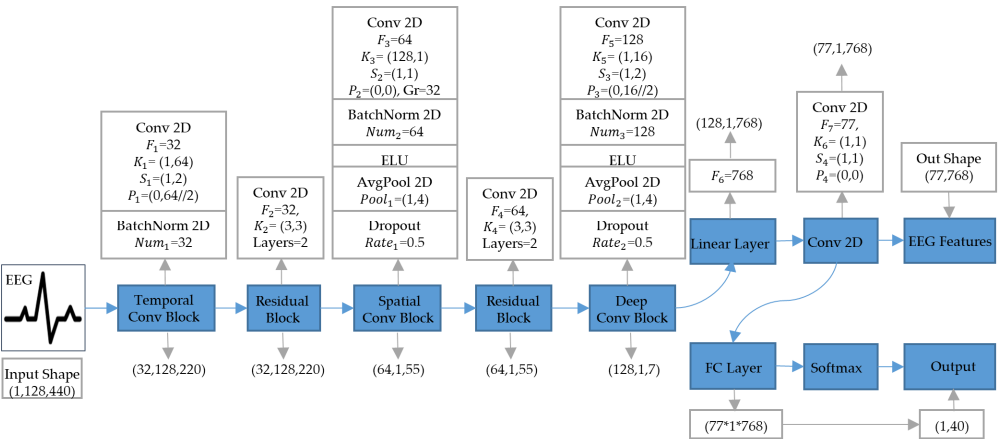

In [38]:
class EEGConDiffusion(nn.Module):
    def __init__(self, channels, samples, classes):
        super(EEGConDiffusion, self).__init__()

        # Temporal conv block
        self.temp_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(1, 64), stride=(1, 2), padding=(0, 64//2)),
            nn.BatchNorm2d(32)
        )

        # Residual block 1
        self.res_block1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding='same')
        )

        # Spatial conv block
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(channels, 1), stride=(1, 1), padding=(0, 0), groups=32),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        # Residual block 2
        self.res_block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        )

        # Deep conv block
        self.deep_conv = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(1, 16), stride=(1, 2), padding=(0, 16//2)),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        # Linear layer
        self.linear_layer = nn.Linear(7, 768)

        # Conv 2d
        self.conv2d = nn.Conv2d(128, 77, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))

        # FC layer and softmax
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(59136, classes),
            # nn.Softmax(dim=1)
        )

    
    def forward(self, x):
        x = self.temp_conv(x)
        x = self.res_block1(x)
        x = self.spatial_conv(x)
        x = self.res_block2(x)
        x = self.deep_conv(x)
        x = self.linear_layer(x)
        x = self.conv2d(x)
        x = self.fc(x)
        return x

In [39]:
encoder = EEGConDiffusion(128, 440, 40).to(DEVICE)
summary(encoder, input_size=(BATCH_SIZE, 1, 128, 440))

C:\Users\Menna Hammed\anaconda3\envs\PBL\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
EEGConDiffusion                          [64, 40]                  --
├─Sequential: 1-1                        [64, 32, 128, 221]        --
│    └─Conv2d: 2-1                       [64, 32, 128, 221]        2,080
│    └─BatchNorm2d: 2-2                  [64, 32, 128, 221]        64
├─Sequential: 1-2                        [64, 32, 128, 221]        --
│    └─Conv2d: 2-3                       [64, 32, 128, 221]        9,248
│    └─Conv2d: 2-4                       [64, 32, 128, 221]        9,248
├─Sequential: 1-3                        [64, 64, 1, 55]           --
│    └─Conv2d: 2-5                       [64, 64, 1, 221]          8,256
│    └─BatchNorm2d: 2-6                  [64, 64, 1, 221]          128
│    └─ELU: 2-7                          [64, 64, 1, 221]          --
│    └─AvgPool2d: 2-8                    [64, 64, 1, 55]           --
│    └─Dropout: 2-9                      [64, 64, 1, 55]           --
├─

In [54]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Trainer():
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.best_loss = 1000000

    def train_epoch(self, model, epoch, optimizer, criterion, train_dataloader):
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_time = time.time()
        
        model.train()
    
        for data in train_dataloader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.detach().item()

        average_running_loss = running_loss / len(train_dataloader)
        accuracy = correct / total * 100
        
        return average_running_loss, accuracy, epoch_time

    def test(self, model, criterion, dataloader):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
            
                outputs = model(inputs.float())
                loss = criterion(outputs, labels)
                running_loss += loss.detach().item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        average_loss = running_loss / len(dataloader)
        accuracy = correct / total * 100
        
        return average_loss, accuracy

    def train(self, model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader, epochs, batch_size, model_dir, run_id):       
        for epoch in range(epochs):
            if epoch == 0:
                print(f'Training model for {epochs} epochs')
 
            train_loss, train_accuracy, epoch_time = self.train_epoch(model, epoch, optimizer, criterion, train_dataloader)
            val_loss, val_accuracy = self.test(model, criterion, val_dataloader)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Scheduler step
            scheduler.step(val_loss)
            print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                best_model = model.state_dict()
                torch.save(best_model, f'models/{model_dir}/{run_id}_{epoch}.pth')
    
            print(f'Epoch {epoch+1}/{epochs}\nTraining Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
            epoch_time = time.time() - epoch_time
            print(f'Epoch Time: {epoch_time:.2f} secs')

        test_loss, test_accuracy = self.test(model, criterion, test_dataloader)
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        return model

In [55]:
# Instantiate the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

# Create the Trainer instance and train the model
trainer = Trainer()
encoder = trainer.train(encoder, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader,
                        epochs=EPOCHS, batch_size=BATCH_SIZE, 
                        model_dir='./EEG-ConDiffusion/', run_id=1)

Training model for 100 epochs
Learning Rate: 0.0001
Epoch 1/100
Training Loss: 0.9682, Train Accuracy: 63.7134
Validation Loss: 1.5236, Validation Accuracy: 43.6769
Epoch Time: 17.78 secs
Learning Rate: 0.0001
Epoch 2/100
Training Loss: 0.9588, Train Accuracy: 64.0955
Validation Loss: 1.4667, Validation Accuracy: 43.8440
Epoch Time: 17.45 secs
Learning Rate: 0.0001
Epoch 3/100
Training Loss: 0.9626, Train Accuracy: 64.5851
Validation Loss: 1.4741, Validation Accuracy: 43.8997
Epoch Time: 17.49 secs
Learning Rate: 0.0001
Epoch 4/100
Training Loss: 0.9651, Train Accuracy: 63.8687
Validation Loss: 1.4961, Validation Accuracy: 44.1783
Epoch Time: 17.58 secs
Learning Rate: 0.0001
Epoch 5/100
Training Loss: 0.9357, Train Accuracy: 65.4209
Validation Loss: 1.4769, Validation Accuracy: 43.7326
Epoch Time: 17.60 secs
Learning Rate: 1e-05
Epoch 6/100
Training Loss: 0.9532, Train Accuracy: 65.0030
Validation Loss: 1.5008, Validation Accuracy: 43.7883
Epoch Time: 17.63 secs
Learning Rate: 1e-05
Ep